In [66]:
import math
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [67]:
fc = pd.read_csv('/Users/lydia/Documents/psych532-ToM-project/neuroimaging_analysis/extension/fc_vals.csv').T

In [68]:
fc.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Unnamed: 0,0.0,1.000000,2.000000,3.000000,4.000000,5.0,6.000000,7.0,8.0,9.0,...,9990.000000,9991.0,9992.000000,9993.0,9994.0,9995.0,9996.0,9997.000000,9998.000000,9999.0
sub-pixar001,0.0,0.148457,0.169583,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,-0.029880,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.098441,0.0
sub-pixar003,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.037535,0.0,0.040662,0.0,0.0,0.0,0.0,-0.011242,0.020721,0.0
sub-pixar005,0.0,0.155015,0.167935,0.000000,-0.040975,0.0,0.000000,0.0,0.0,0.0,...,0.014121,0.0,0.024896,0.0,0.0,0.0,0.0,0.000000,0.203274,0.0
sub-pixar006,0.0,0.068194,0.226563,0.141008,0.000000,0.0,-0.220001,0.0,0.0,0.0,...,0.000000,0.0,-0.015935,0.0,0.0,0.0,0.0,0.000000,0.115414,0.0


In [13]:
participants_df = pd.read_csv('participants.tsv', sep = '\t')

In [69]:
participants_df.head()

,Gender,participant_id,Age,AgeGroup,Child_Adult,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap
0,0,sub-pixar001,4.774812,4yo,child,R,0.80,0.736842,6.0,pass,22.0,13.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
1,1,sub-pixar002,4.856947,4yo,child,R,0.72,0.736842,4.0,inc,18.0,9.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.1
2,1,sub-pixar003,4.153320,4yo,child,R,0.44,0.421053,3.0,inc,15.0,9.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
3,1,sub-pixar004,4.473648,4yo,child,R,0.64,0.736842,2.0,fail,17.0,10.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.2
4,1,sub-pixar005,4.837782,4yo,child,R,0.60,0.578947,4.0,inc,13.0,5.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.2


In [70]:
df_one = pd.get_dummies(participants_df['Gender'])
df_two = pd.concat((df_one, participants_df), axis=1)
df_two = df_two.drop(["Gender"], axis=1)
df_two = df_two.drop(["M"], axis=1)
participants_df = df_two.rename(columns={"F": "Gender"}) # Male =0 and Female =1

KeyError: "['M'] not found in axis"

In [26]:
fc.drop(columns='Gender')

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Unnamed: 0,0.0,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,9990.000000,9991.000000,9992.000000,9993.000000,9994.0,9995.000000,9996.0,9997.000000,9998.000000,9999.0
sub-pixar001,0.0,0.148457,0.169583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.029880,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.098441,0.0
sub-pixar003,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.037535,0.000000,0.040662,0.000000,0.0,0.000000,0.0,-0.011242,0.020721,0.0
sub-pixar005,0.0,0.155015,0.167935,0.000000,-0.040975,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014121,0.000000,0.024896,0.000000,0.0,0.000000,0.0,0.000000,0.203274,0.0
sub-pixar006,0.0,0.068194,0.226563,0.141008,0.000000,0.000000,-0.220001,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.015935,0.000000,0.0,0.000000,0.0,0.000000,0.115414,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-pixar147,0.0,0.000000,0.000000,0.040317,0.038902,0.000000,0.000000,0.000000,-0.147612,0.145184,...,0.000000,-0.065547,0.000000,0.000000,0.0,0.104473,0.0,0.000000,0.183577,0.0
sub-pixar148,0.0,0.000000,0.034963,0.000000,0.000000,0.000000,0.000000,0.047541,0.000000,0.000000,...,0.000000,0.070376,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.155460,0.0
sub-pixar151,0.0,0.000000,0.000000,0.000000,0.029569,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.057540,0.080803,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
sub-pixar152,0.0,0.000000,0.233799,0.000000,0.000000,-0.031946,-0.213849,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.011192,0.0,0.000000,0.034716,0.0


In [71]:
fc['Gender'] = None
for index, value in fc.iloc[:, 0].items():
    if index in participants_df['participant_id'].values:
        gender = participants_df.loc[participants_df['participant_id'] == index, 'Gender'].values[0]
        fc.at[index, 'Gender'] = gender

In [72]:
fc.drop(index=fc.index[0], axis=0, inplace=True)
fc.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Gender
sub-pixar001,0.0,0.148457,0.169583,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.098441,0.0,0
sub-pixar003,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.040662,0.0,0.0,0.000000,0.0,-0.011242,0.020721,0.0,1
sub-pixar005,0.0,0.155015,0.167935,0.000000,-0.040975,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.024896,0.0,0.0,0.000000,0.0,0.000000,0.203274,0.0,1
sub-pixar006,0.0,0.068194,0.226563,0.141008,0.000000,0.0,-0.220001,0.0,0.0,0.000000,...,0.000000,-0.015935,0.0,0.0,0.000000,0.0,0.000000,0.115414,0.0,1
sub-pixar007,0.0,0.020132,0.349057,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.140694,...,-0.028638,0.061480,0.0,0.0,0.008568,0.0,0.000000,0.082131,0.0,0


In [73]:
train_data, test_and_validation_data = train_test_split(fc, test_size=0.2)
validation_data, test_data = train_test_split(test_and_validation_data, test_size=0.5)

In [74]:
scaler = StandardScaler()
scaler.fit_transform(train_data)
scaler.transform(validation_data)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([[ 0.        , -0.70577023, -0.18481224, ...,  0.49563528,
         0.        , -1.10840941],
       [ 0.        , -0.52150367, -0.61399601, ..., -0.64407279,
         0.        , -1.10840941],
       [ 0.        ,  0.37182582,  0.32002936, ..., -0.49887413,
         0.        , -1.10840941],
       ...,
       [ 0.        ,  3.29007794,  0.58511619, ..., -0.79623555,
         0.        ,  0.90219371],
       [ 0.        , -0.52150367, -0.2663298 , ..., -0.75605065,
         0.        , -1.10840941],
       [ 0.        , -0.52150367,  0.38979663, ...,  0.01004891,
         0.        ,  0.90219371]])

In [89]:
logistic_model = LogisticRegression(penalty='l2', C=1e23) #C=1/Lambda

In [90]:
logistic_model.fit(train_data.iloc[:,:-1], train_data['Gender'].astype(int))

LogisticRegression(C=1e+23)

In [91]:
#coefficients
coefficients = logistic_model.coef_
print('Smallest coefficient', coefficients.min())
print('Largest coefficient:', coefficients.max())

Smallest coefficient -2.158145286771782
Largest coefficient: 2.0966642392895594


In [93]:
#predict the probability of the target
logistic_model.predict_proba(validation_data.iloc[:,:-1])

array([[0.14670434, 0.85329566],
       [0.05943885, 0.94056115],
       [0.55413293, 0.44586707],
       [0.90625354, 0.09374646],
       [0.9981569 , 0.0018431 ],
       [0.05174296, 0.94825704],
       [0.08474382, 0.91525618],
       [0.9909525 , 0.0090475 ],
       [0.00289915, 0.99710085],
       [0.68294583, 0.31705417]])

In [94]:
#predict labels
logistic_model.predict(validation_data.iloc[:,:-1])

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [99]:
#find the validation accuracy
logistic_model_val_accuracy = accuracy_score(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:,:-1]))

In [100]:
logistic_model_val_accuracy

0.3

In [119]:
# create a confusion matrix
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    heatmap = sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg']) 
    
    fig = heatmap.get_figure()
    fig.savefig("confusion_matrix.png")

from sklearn.metrics import confusion_matrix
tp = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[1,1]
fp = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[0,1]
tn = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[0,0]
fn = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[1,0]

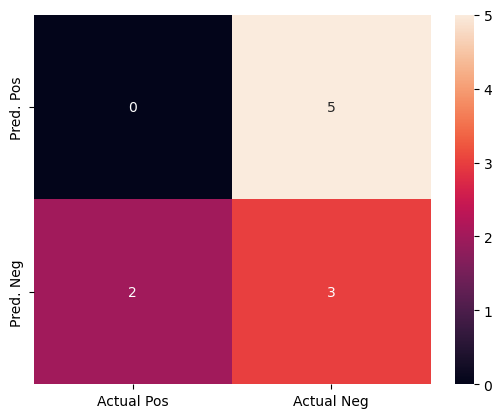

In [120]:
plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)

In [108]:
# set up different regularization penalties to try
l2_penalties = [0.01, 1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = [f'coefficients [L2={l2_penalty:.0e}]' 
                    for l2_penalty in l2_penalties]

coef_table = pd.DataFrame(columns=['features'] + l2_penalty_names)
coef_table['features'] = np.arange(10000)

accuracy_data = []

for l2_penalty, l2_penalty_column_name in zip(l2_penalties, l2_penalty_names):
     model = LogisticRegression(penalty='l2', C=1/l2_penalty, random_state=0, fit_intercept=False)
     model.fit(train_data.iloc[:,:-1], train_data['Gender'].astype(int))
     coef_table[l2_penalty_column_name] = model.coef_[0]

     train_accuracy = accuracy_score(train_data['Gender'].astype(int), model.predict(train_data.iloc[:,:-1]))
     validation_accuracy = accuracy_score(validation_data['Gender'].astype(int), model.predict(validation_data.iloc[:,:-1]))
     accuracy_data.append({'l2_penalty': l2_penalty, 'train_accuracy': train_accuracy, 'validation_accuracy':validation_accuracy})

accuracies_table = pd.DataFrame(accuracy_data)    

In [109]:
coef_table

,features,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,1,-0.044987,-0.018924,-0.012259,-0.008248,-0.001398,-0.000065,-5.746211e-08
2,2,-0.612801,-0.224049,-0.124313,-0.071605,-0.009675,-0.000705,-5.019315e-06
3,3,0.135709,0.051755,0.029688,0.017592,0.002672,0.000299,3.123591e-06
4,4,-0.089656,-0.033475,-0.018882,-0.011021,-0.001630,-0.000186,-1.965576e-06
...,...,...,...,...,...,...,...,...
9995,9995,0.032020,0.012349,0.007298,0.004579,0.000889,0.000131,1.542703e-06
9996,9996,-0.221820,-0.080536,-0.044320,-0.025236,-0.003449,-0.000337,-3.242165e-06
9997,9997,0.010505,0.003977,0.002360,0.001529,0.000366,0.000063,7.855342e-07
9998,9998,-0.109853,-0.041103,-0.023214,-0.013480,-0.001616,-0.000012,9.260042e-07


In [110]:
accuracies_table

,l2_penalty,train_accuracy,validation_accuracy
0,0.01,1.000000,0.2
1,1.00,1.000000,0.2
2,4.00,1.000000,0.3
3,10.00,1.000000,0.2
4,100.00,0.628205,0.2
5,1000.00,0.551282,0.2
6,100000.00,0.551282,0.2


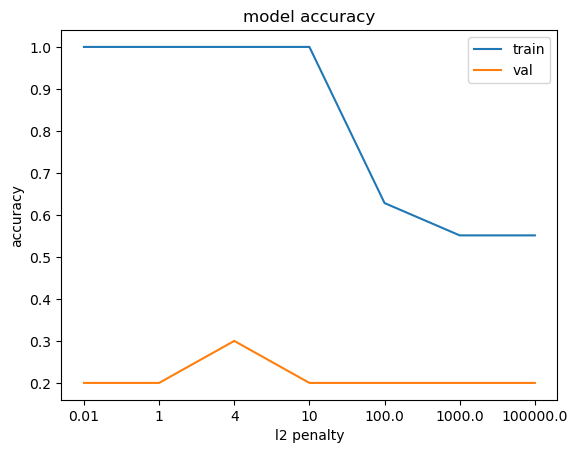

<Figure size 640x480 with 0 Axes>

In [121]:
plt.plot(accuracies_table['train_accuracy'])
plt.plot(accuracies_table['validation_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('l2 penalty')
plt.xticks(range(len(l2_penalties)), l2_penalties)
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.savefig("model_accuracy.png")


In [117]:
positive_features = coef_table.loc[coef_table['coefficients [L2=4e+00]'].nlargest(5).index, 'features']
negative_features = coef_table.loc[coef_table['coefficients [L2=4e+00]'].nsmallest(5).index, 'features']

In [118]:
print(positive_features)
print(negative_features)

857      857
6768    6768
5708    5708
9645    9645
5101    5101
Name: features, dtype: int64
3179    3179
807      807
7366    7366
708      708
5809    5809
Name: features, dtype: int64
